In [27]:
%pip install s4fs

import requests
import pandas as pd
import numpy as np

#------ Visualization
import seaborn as sns
import matplotlib.pyplot as plt
# plt.style.available
plt.style.use('seaborn-colorblind');
pd.options.mode.chained_assignment = 'warn'

from tqdm import tqdm
import mlflow

import warnings
warnings.filterwarnings('default')


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement s4fs (from versions: none)
ERROR: No matching distribution found for s4fs
C:\Users\degio\AppData\Local\Temp/ipykernel_13936/4168271858.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-colorblind');


København = Copenhague

In [2]:
# mlflow.create_experiment('consumo_energia_dinamarca');

In [3]:
mlflow.set_experiment('consumo_energia_dinamarca');

Traceback (most recent call last):
  File "c:\Users\degio\anaconda3\lib\site-packages\mlflow\store\tracking\file_store.py", line 303, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "c:\Users\degio\anaconda3\lib\site-packages\mlflow\store\tracking\file_store.py", line 396, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "c:\Users\degio\anaconda3\lib\site-packages\mlflow\store\tracking\file_store.py", line 1304, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "c:\Users\degio\anaconda3\lib\site-packages\mlflow\store\tracking\file_store.py", line 1297, in _read_helper
    result = read_yaml(root, file_name)
  File "c:\Users\degio\anaconda3\lib\site-packages\mlflow\utils\file_utils.py", line 285, in read_yaml
    raise MissingConfigException(f"Yaml file '{file_path}' does not exist.")
mlflow.exceptions.MissingConfigException: Yaml file 'C:\Users\degio\Downloads\

In [4]:
run = mlflow.start_run()

In [5]:
# I can use the API parameters using '?param = '
max_rows = 100_000_000
city_code = "101"
url = 'https://api.energidataservice.dk/dataset/ConsumptionIndustry' + f"?limit={max_rows}" + '&filter={"MunicipalityNo":["' + city_code + '"]}'
data = requests.get(url)

In [6]:
df = pd.DataFrame(data.json()['records'])
df = df.astype({'HourDK': 'datetime64[ns]'})

Evaluation by hour

In [7]:
df_hour = df.set_index('HourDK').resample('H').agg({'ConsumptionkWh': 'sum'})

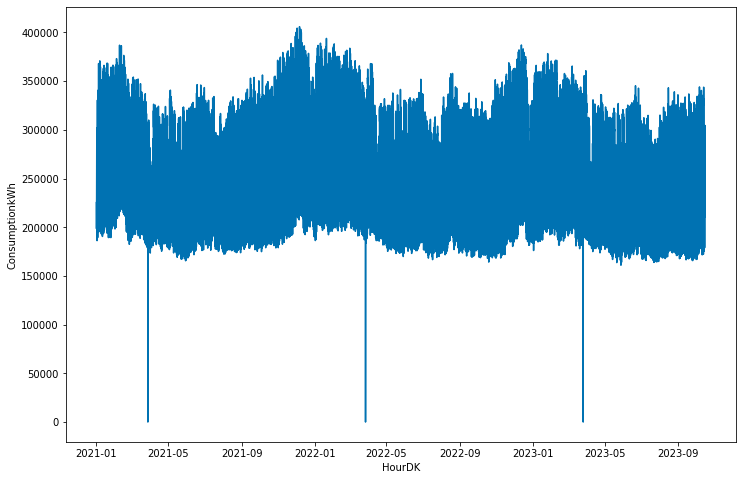

In [8]:
fig = plt.figure(figsize = (12,8))
ax = sns.lineplot(data = df_hour, x = df_hour.index, y = df_hour['ConsumptionkWh'])
plt.show();

mlflow.log_figure(fig, 'Figure_hour_complete.png')

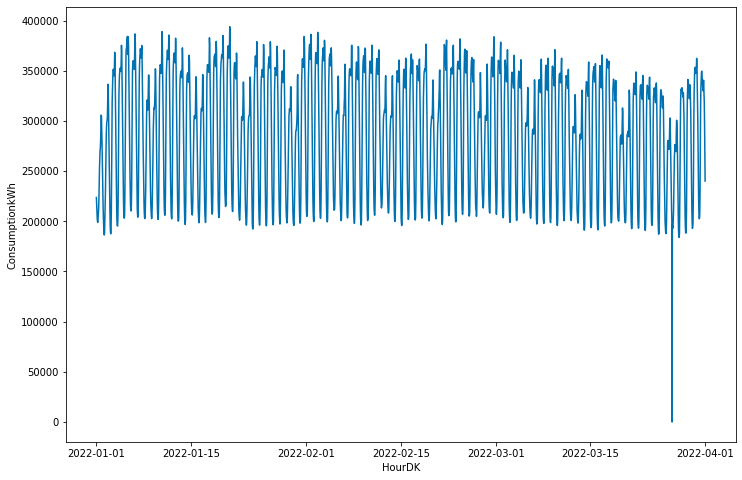

In [9]:
## Producing a sample

df_hour_sample = df_hour['01-2022':'03-2022']

fig = plt.figure(figsize = (12,8))
ax = sns.lineplot(data = df_hour_sample, x = df_hour_sample.index, y = df_hour_sample['ConsumptionkWh'])
plt.show();

mlflow.log_figure(fig, 'Figure_hour_sample.png')

Evaluation by day

In [10]:
df_ = df.copy()

In [11]:
df_ = df_.set_index('HourDK')

In [12]:
df_ = df_.resample('D').agg({'ConsumptionkWh': 'sum'})

mlflow.log_table(df_, 'tabela_dados_resample.csv')

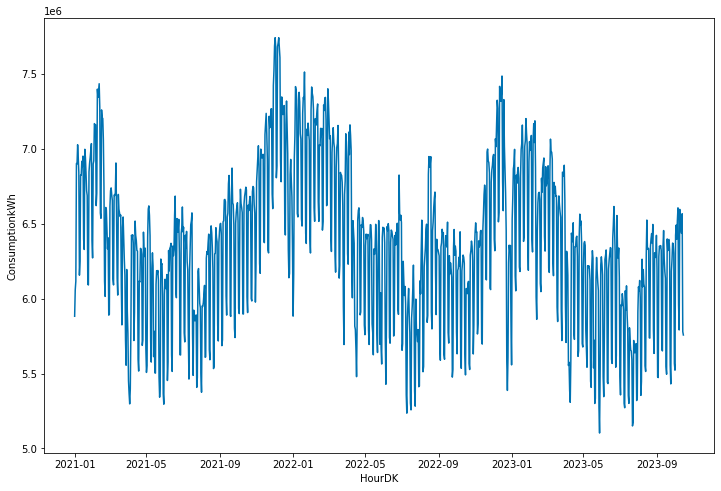

In [13]:
fig = plt.figure(figsize = (12,8))
ax = sns.lineplot(data = df_, x = df_.index, y = df_['ConsumptionkWh'])
plt.show();

mlflow.log_figure(fig, 'Figure_day_complete.png')

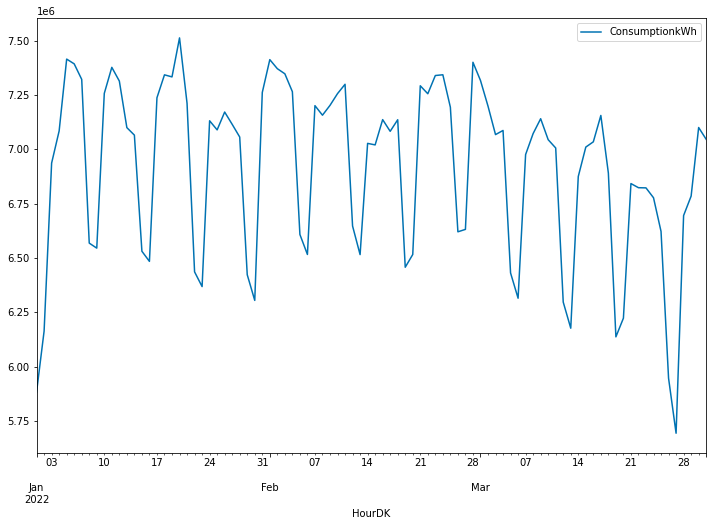

In [14]:
#gettig a sample
df_['01-2022':'03-2022'].plot(figsize = (12,8));

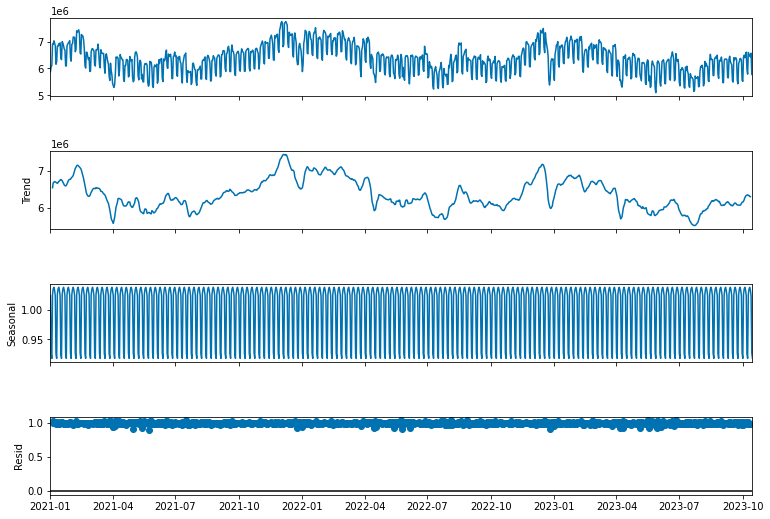

In [15]:
# Time Series Decomposition

from statsmodels.tsa.seasonal import seasonal_decompose

# fig,ax = plt.subplots()
result = seasonal_decompose(df_, model='multiplicative')
fig = result.plot()
fig.set_size_inches(12,8)
plt.show()

mlflow.log_figure(fig, 'decomposition.png')

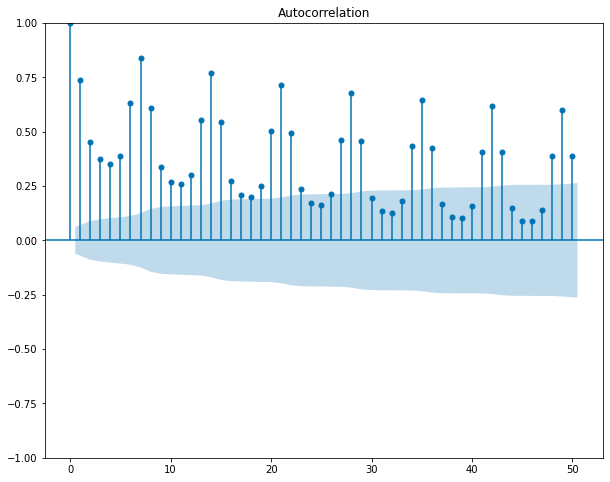

In [16]:
#plotando o gráfico de autocorrelação da serie temporal
import statsmodels.api as sm

fig,ax = plt.subplots(figsize=(10,8))
ax = sm.graphics.tsa.plot_acf(df_, lags = 50, alpha = 0.05, ax = ax)
plt.show()

#It looks like the influence is decreasing, to have a better look at this we must have a pacf graph as well

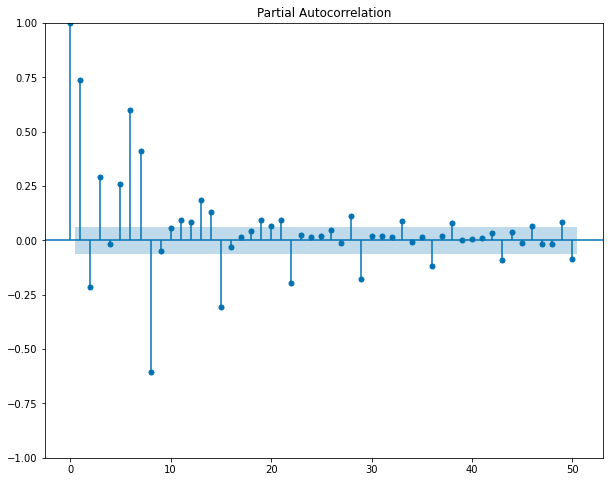

In [17]:
#plotando o gráfico de autocorrelação parcial da serie temporal
import statsmodels.api as sm

fig,ax = plt.subplots(figsize=(10,8))
ax = sm.graphics.tsa.plot_pacf(df_, lags = 50, alpha = 0.05, ax = ax)
plt.show()



In [18]:
# Vamos fazer um teste de estacionariedade para avaliar a serie temporal
results = sm.tsa.stattools.adfuller(df_)
results[1]
#Como o valor de p-value é muito maior que 0.05 não podemos rejeitar a hipotese nula de que os dados são um passeio aleatorio

0.029921724151480353

Testing an AR Model

In [19]:
l = list()
for x in range(25):
    model = sm.tsa.ARIMA(df_, order = (x,0,0))
    results = model.fit()
    l.append(results.aic)


c:\Users\degio\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\degio\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\degio\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\degio\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\degio\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

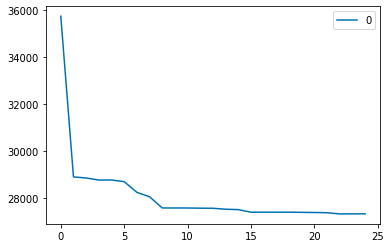

In [20]:
pd.DataFrame(l).plot();

In [21]:
#Testando um ajuste de modelo autoregressivo de primeira ordem
model = sm.tsa.ARIMA(df_, order = (8,0,0))
results = model.fit()

In [22]:
results.summary(), results.params

(<class 'statsmodels.iolib.summary.Summary'>
 """
                                SARIMAX Results                                
 Dep. Variable:         ConsumptionkWh   No. Observations:                 1018
 Model:                 ARIMA(8, 0, 0)   Log Likelihood              -13783.087
 Date:                Tue, 24 Oct 2023   AIC                          27586.174
 Time:                        07:41:49   BIC                          27635.430
 Sample:                    01-01-2021   HQIC                         27604.879
                          - 10-15-2023                                         
 Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 const       6.352e+06   9.06e+04     70.146      0.000    6.17e+06    6.53e+06
 ar.L1          0.8191      0.023     35.921      0.000       0.774   

Forecasting

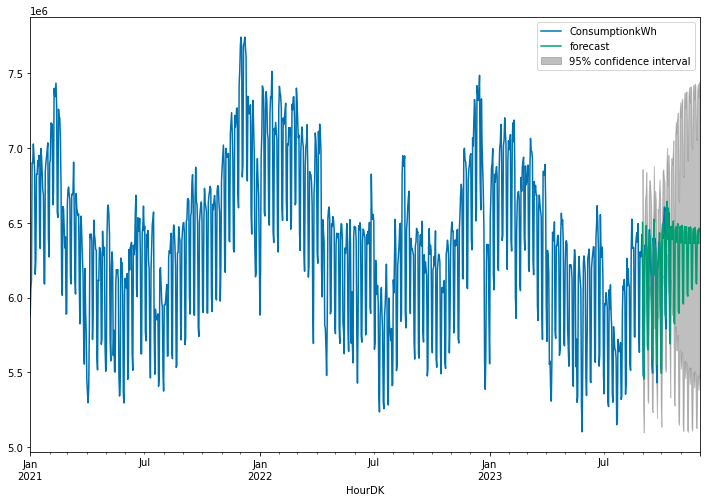

In [23]:
from statsmodels.graphics.tsaplots import plot_predict

fig, ax = plt.subplots(figsize = (12,8))
df_.plot(ax = ax)
plot_predict(results, '2023-09-01','2023-12-01', alpha = 0.05, ax = ax)
plt.show()

In [24]:
mlflow.end_run()

Rolling Windowns - Média movel

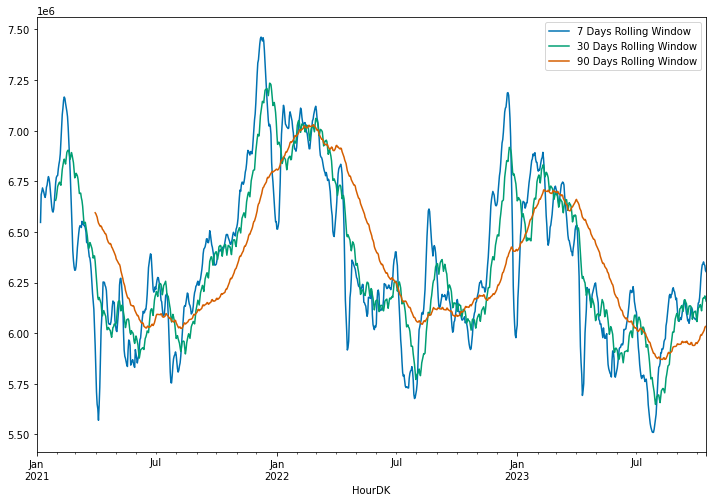

In [41]:
fig, ax = plt.subplots(figsize = (12,8))
df_.rolling(window= 7).mean().plot(ax = ax)
df_.rolling(window= 30).mean().plot(ax = ax)
df_.rolling(window= 90).mean().plot(ax = ax)
ax.legend(['7 Days Rolling Window', '30 Days Rolling Window', '90 Days Rolling Window'])

Evaluating Sazionality by month

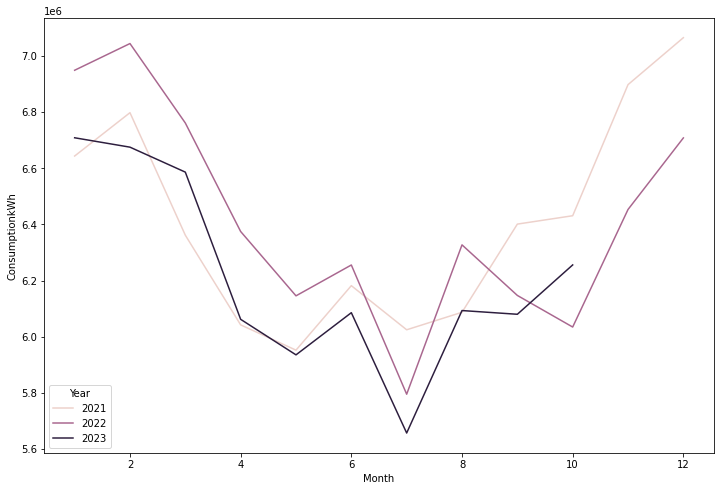

In [67]:
df_season = df_.groupby([df_.index.month, df_.index.year]).mean()
df_season.index = df_season.index.set_names(['Month', 'Year'])
df_season.reset_index(inplace=True)

plt.figure(figsize=(12,8))
sns.lineplot(data = df_season, x = 'Month', hue='Year', y = 'ConsumptionkWh')
plt.show();

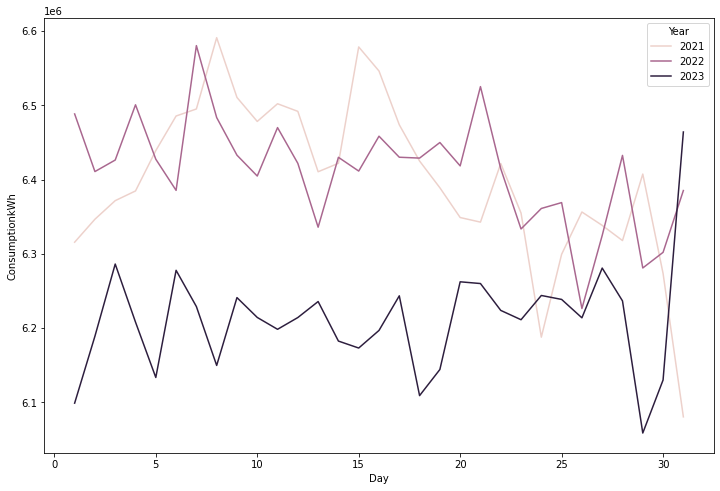

In [74]:
df_season = df_.groupby([df_.index.day, df_.index.year]).mean()
df_season.index = df_season.index.set_names(['Day', 'Year'])
df_season.reset_index(inplace=True)

plt.figure(figsize=(12,8))
sns.lineplot(data = df_season, x = 'Day', hue='Year', y = 'ConsumptionkWh')
plt.show();

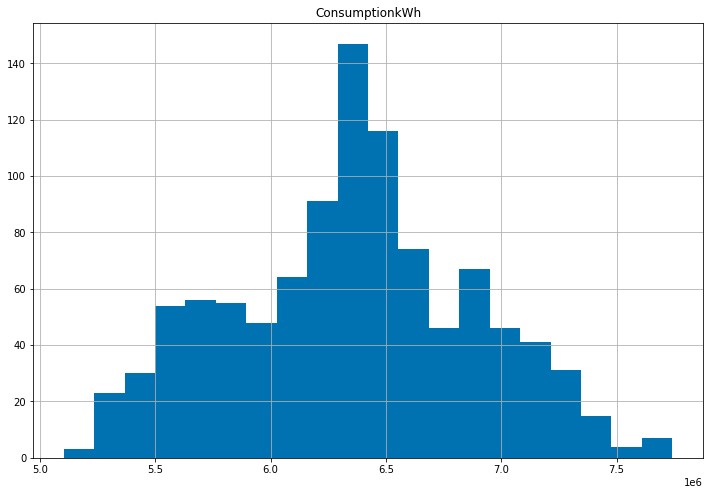

In [79]:
df_.hist(figsize=(12,8), bins = 20);

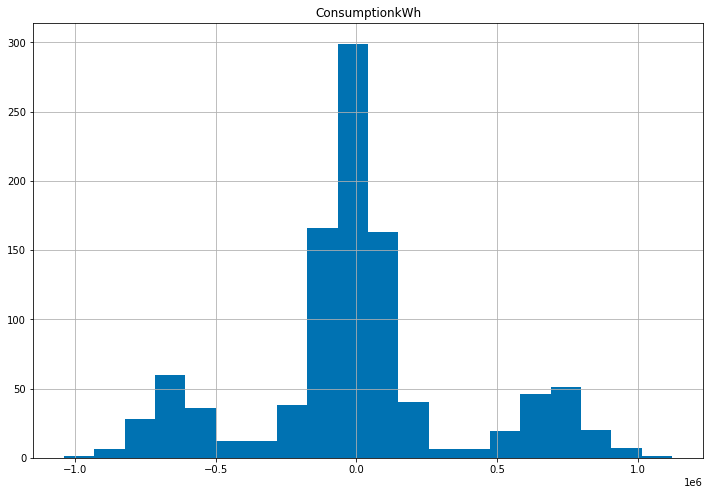

In [83]:
#Histogram of the first difference
df_.diff(1).hist(figsize=(12,8), bins = 20);